In [50]:
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from bottleneck_networks_tf2 import r2_score, ElasticNet

from plot_utils import adjust_spines

### Load data

In [2]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [3]:
with open('data/sbnn/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [4]:
with open('data/sbnn/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [5]:
with open('data/sbnn/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [6]:
with open('data/sbnn/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [7]:
with open('data/sbnn/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [8]:
with open('data/sbnn/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [9]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

### Prective Performance

#### Training curves

In [10]:
print(r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank16, axis=0)[0, :][np.isclose(n_rank16, 25, atol=3)][0])

0.39811512463141036 +/- 0.016844028073453247


In [11]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=3)][0])

0.35036089702192025 +/- 0.019618703438733235


In [12]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.39728141725063326 +/- 0.02221465147618321


In [13]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.3740154504776001 +/- 0.021394069010219213


In [14]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.3740154504776001 +/- 0.021394069010219213


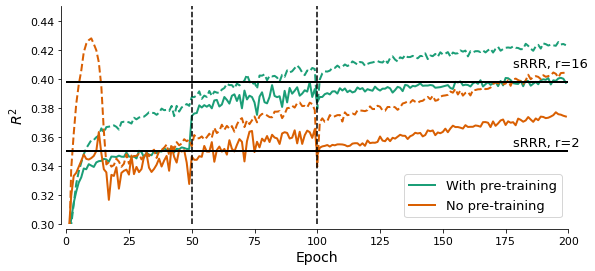

In [36]:
# All together in one plot
linewidth = 2
#sns_styleset()

epochs_used=200
fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
ax.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='No pre-training')
ax.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax.set_ylim([0.3,0.45])
ax.set_xlim([0,200])
ax.set_xticks(np.arange(0, 225, 25))
ax.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)]+0.01), fontsize=13)
ax.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)]+0.003), fontsize=13)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel(r'$R^2$', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
ax.legend(loc='lower right', fontsize=13)
ax.vlines(x=50, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', color='black')
ax.vlines(x=100, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', color='black')
sns.despine()

adjust_spines(ax, ["bottom", "left"])

plt.savefig('figures/sBNN_training_curves.pdf', bbox_inches='tight',
    pad_inches=0.15)

#### Individual features

In [18]:
with open('data/sbnn/ind_feature_scores.pickle', 'rb') as f:
     scala_individual_R2_scores, scala_individual_R2_scores_std=pickle.load(f)

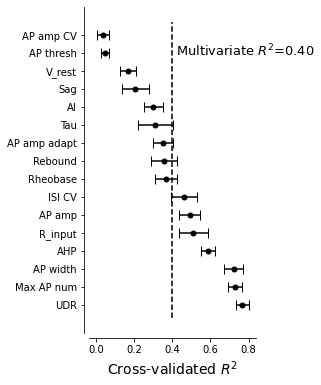

In [37]:
scala_order=np.argsort(np.array([scala_individual_R2_scores[key] for key in scala_individual_R2_scores]))[::-1]

fig, ax = plt.subplots(1,1,figsize=(3,6))

ax.errorbar(
    x=np.array([scala_individual_R2_scores[key] for key in scala_individual_R2_scores])[scala_order],
    y=np.array([key for key in scala_individual_R2_scores])[scala_order],
    xerr=np.array([scala_individual_R2_scores_std[key] for key in scala_individual_R2_scores_std])[scala_order],
    marker='.', color='k', markersize=10, capsize=5, linestyle='none')
ax.vlines(np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0),
          ymin=ax.get_ylim()[0],
          ymax=ax.get_ylim()[1],
          linestyle='dashed',
          color='black')
ax.annotate(r'Multivariate $R^2$={0:.2f}'.format(np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0)),
           (np.mean(r2_freeze_unfreeze_hist[:,2,0,-1],axis=0)+0.02,
            ax.get_ylim()[0]+1.7*(ax.get_ylim()[1]-ax.get_ylim()[0])/2),
            fontsize=13)
adjust_spines(ax, ["bottom", "left"])
ax.set_xlabel(r'Cross-validated $R^2$', fontsize=14)
plt.savefig('figures/sBNN_ind_features.pdf',
            bbox_inches = 'tight',
            pad_inches = 0)

#### Different lasso penalties

In [45]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])
cvfold_id=1111

In [51]:
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('data/sbnn/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format(cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
weights_after_unfreezing = np.array(weights_after_unfreezing)

2023-08-13 13:36:51.964527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 13:36:53.796558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11419 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:81:00.0, compute capability: 6.1


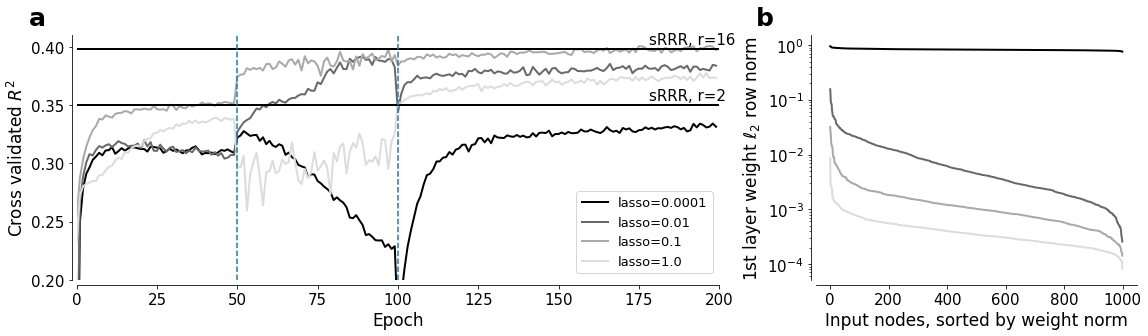

In [55]:
# Everything in one figure for the paper
linewidth = 2
epochs_used = 200
#colours = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824']
colours = ['black', 'dimgrey', 'darkgrey', 'gainsboro']
#colours = ['orangered', 'darkgreen', 'turquoise', 'deeppink']
# suppressing "mean of empty slice" warnings


fig = plt.figure(figsize=(19, 4.5))
widths = [2, 1]
heights = [1]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                          height_ratios=heights)

ax1 = fig.add_subplot(spec[0, 0])
for j, l1 in enumerate(l1_params):
    ax1.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis = (0))[j,0,:].T, \
             c = colours[j], linewidth=linewidth, label='lasso={}'.format(l1))
ax1.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=3)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax1.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=3)][0]+0.004), fontsize=15)
ax1.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0]+0.004), fontsize=15)
ax1.set_ylim([0.2, 0.41])
ax1.set_xlim([0, epochs_used])
ax1.set_xlabel('Epoch', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.legend(loc='lower right', fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_xticks(np.arange(0, 225, 25))
ax1.vlines(x=50, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.vlines(x=100, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')

ax2 = fig.add_subplot(spec[0, 1])
for j, l1 in enumerate(l1_params):
    ax2.plot(range(1000), np.sort(np.linalg.norm(weights_after_unfreezing, ord=2, axis=2), axis = 1)[j, ::-1].T, \
             c = colours[j], label = 'lasso={}'.format(l1), linewidth=linewidth)
ax2.set_ylabel(r'1st layer weight $\ell_2$ row norm', fontsize = 17)
ax2.set_xlabel('Input nodes, sorted by weight norm', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_yscale('log')

plt.text(-0.075, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.185, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')

adjust_spines(ax1, ["bottom", "left"])
adjust_spines(ax2, ["bottom", "left"])

plt.savefig('figures/sBNN_different_lasso.pdf', bbox_inches = 'tight',
   pad_inches = 0.1)

### Visualization